# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}

sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000226555.1,ENSG00000226555,AGKP1,7.2714420,100.72642,1.972766e-256,< 2e-16,****,Male Bias,AGKP1
ENSG00000229236.1,ENSG00000229236,TTTY10,7.4217177,95.27135,1.480656e-248,< 2e-16,****,Male Bias,TTTY10
ENSG00000176728.7,ENSG00000176728,TTTY14,8.8138987,94.65882,8.698526e-248,< 2e-16,****,Male Bias,TTTY14
ENSG00000260197.1,ENSG00000260197,,7.0194942,91.62666,3.781626e-243,< 2e-16,****,Male Bias,ENSG00000260197
ENSG00000241859.6,ENSG00000241859,ANOS2P,7.6385157,87.34427,2.889913e-236,< 2e-16,****,Male Bias,ANOS2P
ENSG00000229807.10,ENSG00000229807,XIST,-10.3166448,-69.62343,3.372116e-204,< 2e-16,****,Female Bias,XIST
ENSG00000005889.15,ENSG00000005889,ZFX,-0.6694706,-40.17472,2.771661e-130,< 2e-16,****,Female Bias,ZFX
ENSG00000126012.11,ENSG00000126012,KDM5C,-0.4631341,-28.24643,1.889508e-89,< 2e-16,****,Female Bias,KDM5C
ENSG00000130021.13,ENSG00000130021,PUDP,-0.5409699,-21.96438,5.505647e-65,< 2e-16,****,Female Bias,PUDP


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
"Detected 360 column names but the data has 361 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,ENSG00000130021.13,ENSG00000005889.15,ENSG00000215301.9,ENSG00000126012.11,ENSG00000229807.10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R10424,0.9741964,-1.3321707,-0.6113142,-1.6435321,-1.972946
R12195,-0.2881043,-0.7644918,-0.6949357,-0.3443345,-1.008035


### Load pheno data

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv'
pheno <- data.table::fread(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("V1")
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,Control
R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,Schizo


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 360  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000130021.13
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,Control,0.9741964
2,R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,Schizo,-0.2881043


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R10424,Male,ENSG00000130021.13,0.9741964,ENSG00000130021,PUDP,-0.5409699,-21.96438,5.505647e-65,< 2e-16,****,Female Bias,PUDP
R10424,Male,ENSG00000005889.15,-1.3321707,ENSG00000005889,ZFX,-0.6694706,-40.17472,2.771661e-130,< 2e-16,****,Female Bias,ZFX


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


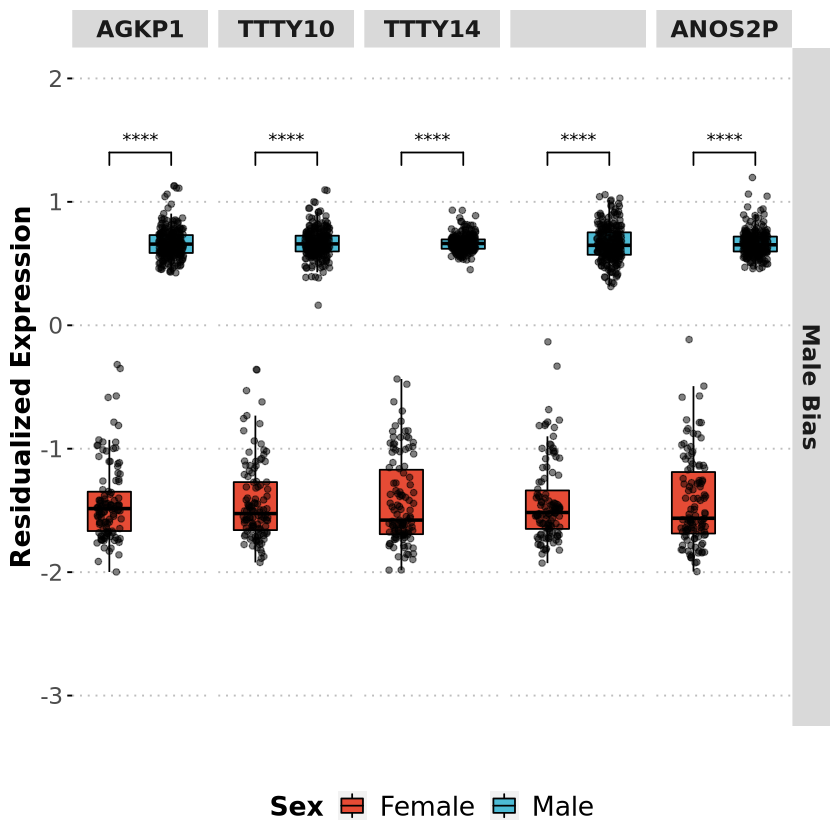

In [8]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=1.4) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Male Bias") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), fill="Sex", xlab='', 
                  panel.labs.font=list(face='bold', size = 16), palette="npg", outlier.shape=NA,
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 2),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


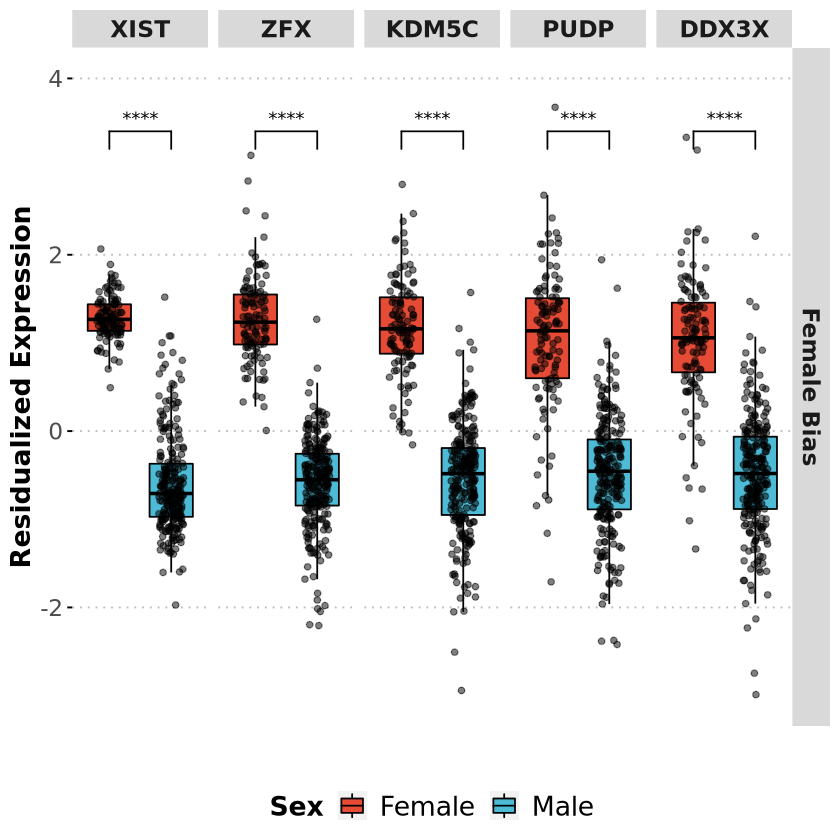

In [9]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.4) %>% filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=='Female Bias') %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16), 
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 4),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

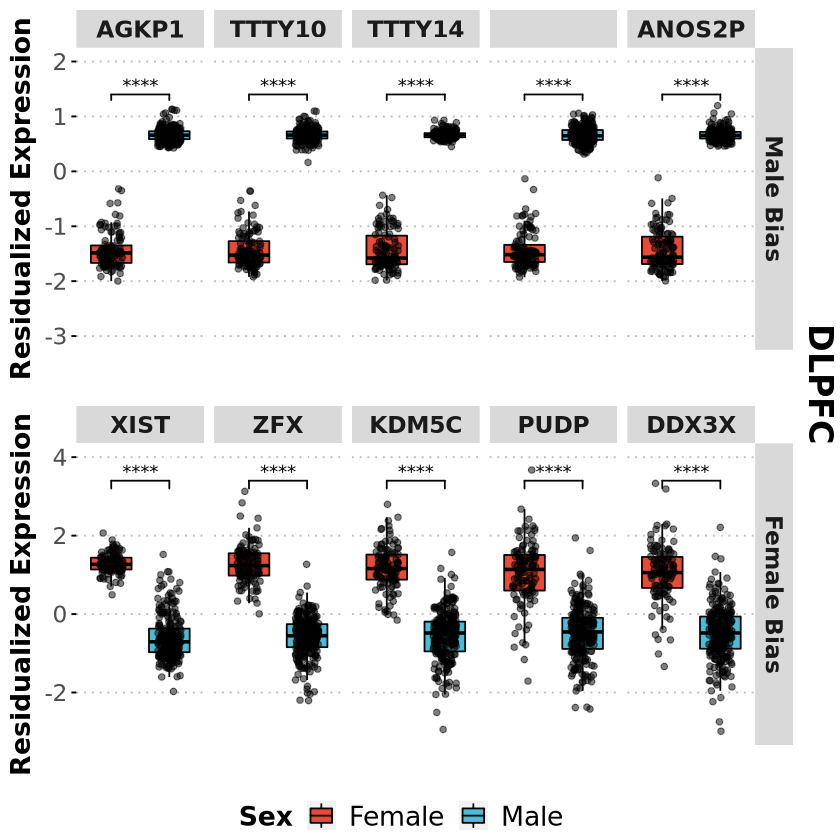

In [10]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow=2, common.legend=TRUE, legend='bottom')
figure <- annotate_figure(figure, 
                          right=text_grob("DLPFC", size=22, rot=-90, face='bold', hjust=0.8))
figure

In [11]:
save_ggplots('dlpfc_topSig_boxplot', figure, 12, 8)

## Autosomal only

### Differential expressed genes

In [ ]:
genes = read.csv('../../metrics_summary/_m/autosomal_DEG.csv')
genes = genes %>% rename("gencodeID" = "Feature") %>% 
        filter(adj.P.Val < 0.05) %>%  
        select(gencodeID, ensemblID, Symbol, logFC, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(logFC > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(logFC < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(as.character(sig_genes$Symbol[xx]) == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

### Load residualized expression

In [ ]:
resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

### Merge dataframe

In [ ]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

### Melt data frame

In [ ]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    mutate_if(is.character, as.factor) %>% inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

### Initial ggplot with ggpubr

In [ ]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.5) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction == "Male Bias") %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                    facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16),
                    ylab='Residualized Expression', add='jitter', ylim=c(-6.5, 5), 
                    add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

In [ ]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=4.5) %>% filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Female Bias") %>%
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16),    
                  ylab='Residualized Expression', add='jitter', ylim=c(-5, 5.5),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

In [ ]:
figure2 <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, common.legend=TRUE, legend='bottom')
figure2 <- annotate_figure(figure2, right=text_grob("DLPFC", size=22, rot=-90, face='bold', hjust=0.8))
figure2

In [ ]:
save_ggplots('dlpfc_topSig_autosomal_boxplot', figure2, 12, 8)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()